<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the data from GitHub

In [1]:
# import os
# if not os.path.exists('GEOMAR-DeepLearning'):
#     print(f'GEOMAR-DeepLearning does not exist')
#     !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
#     %cd GEOMAR-DeepLearning/app/backend
#     !git pull
#     !pip install -r requirements.txt
# else:
#     print(f'GEOMAR-DeepLearning exists')
#     %cd GEOMAR-DeepLearning/app/backend
#     !git pull
#     !pip install -r requirements.txt

## Import Libaries

In [9]:
# import all necessary libraries
import os
import datetime
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
from tqdm import tqdm
from pathlib import Path
from utils.OpenMeteoWeather import OpenMeteoWeather
import math

from datetime import datetime
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

## Download Training Data

In [10]:
START_DATE = '2022-12-03'
END_DATE = '2025-03-01'
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    
    "minimum_longitude":9.10,
    "maximum_longitude":30.20,
    "minimum_latitude":53.10,
    "maximum_latitude":65.00,

    # "minimum_longitude":9.85083510071235,
    # "maximum_longitude":10.926709174713364,
    # "minimum_latitude":54.25206332481298,
    # "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [11]:
# Download Data
minimum_latitude = BBOX['minimum_latitude']
maximum_latitude = BBOX['maximum_latitude']
minimum_longitude = BBOX['minimum_longitude']
maximum_longitude = BBOX['maximum_longitude']

copernicus = AdvancedCopernicus()
points = 20
latitudes = np.linspace(minimum_latitude, maximum_latitude, points)
longitudes = np.linspace(minimum_longitude, maximum_longitude, points)

In [12]:
# zip latitudes and longitudes
coordinates = set([(float(lat), float(lon)) for lat in latitudes for lon in longitudes])

# plot the coordinates to folium
folium_map = folium.Map(location=[minimum_latitude, minimum_longitude], zoom_start=4)
for lat, lon in coordinates:
    folium.CircleMarker(location=[lat, lon], radius=4, color='red').add_to(folium_map)
folium_map

### Ocean Data

In [18]:


# Calculate Radius


variables = ["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"]
df_ocean = pd.DataFrame()
for lat, lon in tqdm(coordinates, total=len(coordinates)):
    #print(lat, lon)

    # Check if file exists
    path = Path("data")
    file = f'Copernicus_{START_DATE}_{END_DATE}_lat{lat}-lon{lon}.nc'
    file_path = Path(path, file)

    if file in os.listdir("data"):
        #print(f"File {file} already exists")
        data = xr.open_dataset(file_path)
        data = data.to_dataframe().reset_index()
        df_ocean = pd.concat([df_ocean, data], axis=0)

    else:
        radius = 0.01 
        if lon-radius < BBOX['minimum_longitude'] or lon+radius > BBOX['maximum_longitude'] or lat-radius < BBOX['minimum_latitude'] or lat+radius > BBOX['maximum_latitude']:
            radius = 0

        data = copernicus.get_subset(
            dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
            dataset_version="202411",
            variables=variables,
            minimum_longitude=lon-radius,
            maximum_longitude=lon+radius,
            minimum_latitude=lat-radius,
            maximum_latitude=lat+radius,
    
            start_datetime=START_DATE,
            end_datetime=END_DATE,
            minimum_depth=0.5016462206840515,
            maximum_depth=0.5016462206840515,
            coordinates_selection_method="strict-inside",
            disable_progress_bar=False,
            output_filename=file,
            delete_file=False)
        
    
        data = data.to_dataframe().reset_index()
        df_ocean = pd.concat([df_ocean, data], axis=0)

print(df_ocean.info())
display(df_ocean.head())

100%|██████████| 400/400 [01:45<00:00,  3.77it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 8570452 entries, 0 to 19656
Data columns (total 15 columns):
 #   Column     Dtype         
---  ------     -----         
 0   depth      float32       
 1   latitude   float32       
 2   longitude  float32       
 3   time       datetime64[ns]
 4   bottomT    float32       
 5   mlotst     float32       
 6   siconc     float32       
 7   sithick    float32       
 8   sla        float32       
 9   so         float32       
 10  sob        float32       
 11  thetao     float32       
 12  uo         float32       
 13  vo         float32       
 14  wo         float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 588.5 MB
None


,depth,latitude,longitude,time,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,0.501646,57.474888,27.986366,2022-12-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.501646,57.474888,27.986366,2022-12-03 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.501646,57.474888,27.986366,2022-12-03 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.501646,57.474888,27.986366,2022-12-03 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.501646,57.474888,27.986366,2022-12-03 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
def process_df(df:pd.DataFrame)->pd.DataFrame:
    # df = df.dropna(axis=1, how="all")
    # df = df.dropna(axis=0, how="any")
    # drop cols with lot of missing values
    df = df.drop(columns=['depth'], axis=1)
    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")
    
    df = df.groupby(by=['time', 'latitude', 'longitude']).mean().reset_index()
    df = df.reset_index(drop=True)

    return df

In [ ]:
df_ocean = df_ocean.dropna(axis=1, how="all")
df_ocean = df_ocean.dropna(axis=0, how="any")
df_ocean = process_df(df_ocean)
df_ocean.info()
df_ocean.head()

KeyError: "['depth'] not found in axis"

In [23]:
df_ocean.to_csv("data/df_ocean.csv", index=False)

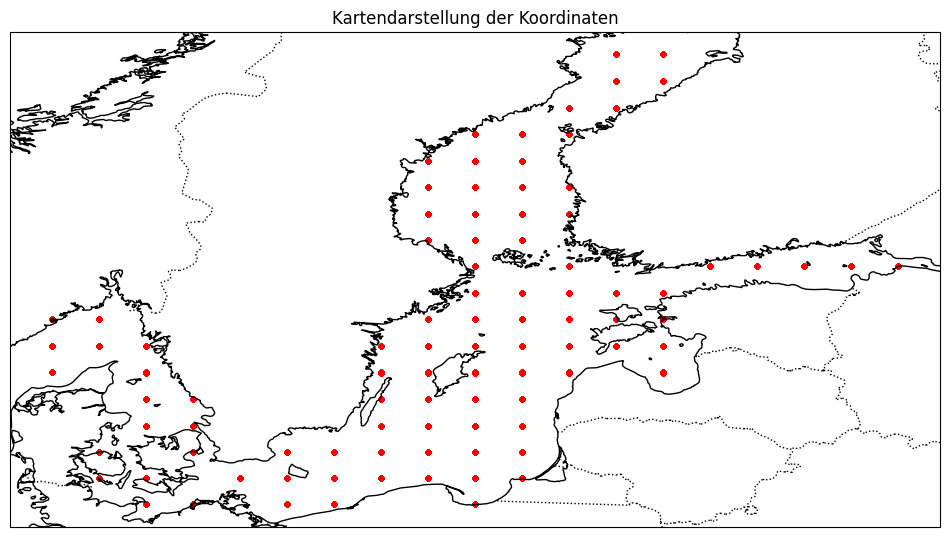

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Figure mit Kartenprojektion erstellen
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Küstenlinien und Länder hinzufügen
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Punkte plotten
ax.scatter(df_ocean['longitude'], df_ocean['latitude'], c='red', s=8, alpha=0.7, transform=ccrs.PlateCarree())

# Achsen und Titel
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Kartendarstellung der Koordinaten")

plt.show()


In [17]:
import folium

df_map = df_ocean.groupby(by=["latitude", "longitude"]).mean().reset_index()
# Create a folium map centered around the average lat/lon
map_center = [df_map["latitude"].mean(), df_map["longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=5)



df_map = df_ocean.groupby(by=["latitude", "longitude"]).mean().reset_index()

for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        #popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude']}, Lon: {row['longitude']}",
        icon=folium.Icon(color="red")
    ).add_to(m)


m

### Weather Data

In [13]:
# Get unique latitudes and longitudes
coordinates = sorted(set(zip(df_ocean['latitude'], df_ocean['longitude'])))
print(f'Number of unique coordinates: {len(coordinates)}')

list(coordinates)

Number of unique coordinates: 95


[(54.3582763671875, 11.319351196289062),
 (54.3582763671875, 12.430458068847656),
 (54.3582763671875, 14.652671813964844),
 (54.3582763671875, 15.763778686523438),
 (54.3582763671875, 19.097206115722656),
 (54.97493362426758, 10.208244323730469),
 (54.97493362426758, 11.319351196289062),
 (54.97493362426758, 13.54156494140625),
 (54.97493362426758, 14.652671813964844),
 (54.97493362426758, 15.763778686523438),
 (54.97493362426758, 16.874916076660156),
 (54.97493362426758, 17.986061096191406),
 (54.97493362426758, 19.097206115722656),
 (54.97493362426758, 20.208351135253906),
 (55.60825729370117, 10.208244323730469),
 (55.60825729370117, 12.430458068847656),
 (55.60825729370117, 14.652671813964844),
 (55.60825729370117, 15.763778686523438),
 (55.60825729370117, 16.874916076660156),
 (55.60825729370117, 17.986061096191406),
 (55.60825729370117, 19.097206115722656),
 (55.60825729370117, 20.208351135253906),
 (56.22491455078125, 11.319351196289062),
 (56.22491455078125, 12.430458068847656)

In [11]:
latitudes = [lat for lat, lon in coordinates]
longitudes = [lon for lat, lon in coordinates]

    
print(latitudes, longitudes)
end_date_dt = datetime.strptime(END_DATE, "%Y-%m-%d %H:%M:%S")

#start_str = start_date_dt.strftime("%Y-%m-%d")
end_str = end_date_dt.strftime("%Y-%m-%d")
open_meteo_weather = OpenMeteoWeather(
    latitudes=latitudes,
    longitudes=longitudes,
    start_date=START_DATE,
    end_date=end_str
)
data = open_meteo_weather.get_weather_dataframe()

[54.42494201660156, 54.42494201660156, 54.42494201660156, 55.7415885925293, 55.7415885925293, 55.7415885925293, 57.05823516845703, 57.05823516845703, 57.05823516845703, 58.39154052734375, 58.39154052734375, 58.39154052734375, 58.39154052734375, 59.708187103271484, 59.708187103271484, 59.708187103271484, 59.708187103271484, 61.02483367919922, 61.02483367919922, 62.35814666748047, 62.35814666748047, 63.6747932434082, 64.9912109375] [11.430461883544922, 13.791563987731934, 16.124893188476562, 16.124893188476562, 18.48607635498047, 20.819480895996094, 11.430461883544922, 18.48607635498047, 20.819480895996094, 9.097137451171875, 18.48607635498047, 20.819480895996094, 23.15288543701172, 20.819480895996094, 23.15288543701172, 25.514068603515625, 27.84747314453125, 18.48607635498047, 20.819480895996094, 18.48607635498047, 20.819480895996094, 20.819480895996094, 23.15288543701172]


Processing weather data: 100%|██████████| 46/46 [00:00<00:00, 235.05it/s]


In [12]:

df_weather = data.copy()
ncols = len(df_weather.columns)

# drop cols with lot of missing values
df_weather = df_weather.dropna(axis=1, thresh=0.9*len(df_weather))
df_weather = df_weather.dropna(axis=0, how="any")
df_weather.info()
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
Index: 35926 entries, 0 to 36431
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   latitude                    35926 non-null  float64       
 1   longitude                   35926 non-null  float64       
 2   time                        35926 non-null  datetime64[ns]
 3   temperature_2m              35926 non-null  float32       
 4   relative_humidity_2m        35926 non-null  float32       
 5   dew_point_2m                35926 non-null  float32       
 6   apparent_temperature        35926 non-null  float32       
 7   precipitation               35926 non-null  float32       
 8   rain                        35926 non-null  float32       
 9   showers                     35926 non-null  float32       
 10  snowfall                    35926 non-null  float32       
 11  weather_code                35926 non-null  float32       


,latitude,longitude,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,54.424942,11.430462,2024-12-31 23:00:00,3.80,88.977997,2.15,-5.254288,0.2,0.2,0.0,0.0,51.0,1010.599976,1010.599976,100.0,100.0,51.0,100.0,0.017204,0.088631,49.953808,218.563095,68.760002
1,54.424942,11.430462,2025-01-01 00:00:00,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996
2,54.424942,11.430462,2025-01-01 01:00:00,4.65,88.108688,2.85,-4.481308,0.4,0.4,0.0,0.0,51.0,1008.099976,1008.099976,100.0,100.0,100.0,100.0,0.020372,0.101490,51.350502,222.300644,68.400002
3,54.424942,11.430462,2025-01-01 02:00:00,5.05,88.456490,3.30,-4.119362,0.6,0.6,0.0,0.0,53.0,1007.200012,1007.200012,100.0,100.0,100.0,100.0,0.020272,0.101308,52.190067,224.161682,70.199997
4,54.424942,11.430462,2025-01-01 03:00:00,5.45,88.491531,3.70,-3.849421,0.4,0.4,0.0,0.0,51.0,1006.299988,1006.299988,100.0,100.0,100.0,100.0,0.021022,0.103846,53.610092,226.768631,70.919998


In [13]:
cords = set(zip(df_weather['latitude'].astype(float), df_weather['longitude'].astype(float)))
cords

{(54.42494201660156, 11.430461883544922),
 (54.42494201660156, 13.791563987731934),
 (54.42494201660156, 16.124893188476562),
 (55.7415885925293, 16.124893188476562),
 (55.7415885925293, 18.48607635498047),
 (55.7415885925293, 20.819480895996094),
 (57.05823516845703, 11.430461883544922),
 (57.05823516845703, 18.48607635498047),
 (57.05823516845703, 20.819480895996094),
 (58.39154052734375, 9.097137451171875),
 (58.39154052734375, 18.48607635498047),
 (58.39154052734375, 20.819480895996094),
 (58.39154052734375, 23.15288543701172),
 (59.708187103271484, 20.819480895996094),
 (59.708187103271484, 23.15288543701172),
 (59.708187103271484, 25.514068603515625),
 (59.708187103271484, 27.84747314453125),
 (61.02483367919922, 18.48607635498047),
 (61.02483367919922, 20.819480895996094),
 (62.35814666748047, 18.48607635498047),
 (62.35814666748047, 20.819480895996094),
 (63.6747932434082, 20.819480895996094),
 (64.9912109375, 23.15288543701172)}

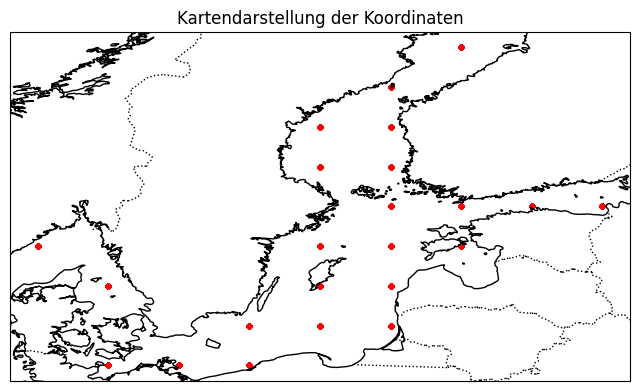

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Figure mit Kartenprojektion erstellen
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Küstenlinien und Länder hinzufügen
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Punkte plotten
ax.scatter(df_weather['longitude'], df_weather['latitude'], c='red', s=10, alpha=0.7, transform=ccrs.PlateCarree())

# Achsen und Titel
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Kartendarstellung der Koordinaten")

plt.show()

In [15]:
df_weather['latitude'].nunique(), df_weather['longitude'].nunique()
#df_weather['time'].nunique()

(9, 9)

In [16]:

df_weather = process_df(df_weather)
#df_weather.groupby(by=['time', 'latitude', 'longitude']).mean()

df_weather.rename(columns={'latitude': 'latitude_weather', 'longitude': 'longitude_weather'}, inplace=True)
df_weather.head()

,time,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2024-12-31 23:00:00,54.424942,11.430462,3.80,88.977997,2.15,-5.254288,0.2,0.2,0.0,0.0,51.0,1010.599976,1010.599976,100.0,100.0,51.0,100.0,0.017204,0.088631,49.953808,218.563095,68.760002
1,2025-01-01 00:00:00,54.424942,11.430462,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996
2,2025-01-01 01:00:00,54.424942,11.430462,4.65,88.108688,2.85,-4.481308,0.4,0.4,0.0,0.0,51.0,1008.099976,1008.099976,100.0,100.0,100.0,100.0,0.020372,0.101490,51.350502,222.300644,68.400002
3,2025-01-01 02:00:00,54.424942,11.430462,5.05,88.456490,3.30,-4.119362,0.6,0.6,0.0,0.0,53.0,1007.200012,1007.200012,100.0,100.0,100.0,100.0,0.020272,0.101308,52.190067,224.161682,70.199997
4,2025-01-01 03:00:00,54.424942,11.430462,5.45,88.491531,3.70,-3.849421,0.4,0.4,0.0,0.0,51.0,1006.299988,1006.299988,100.0,100.0,100.0,100.0,0.021022,0.103846,53.610092,226.768631,70.919998


### Download Target Data

In [36]:
target_file = f'target_output.nc'

target_min_lon = BBOX['target_min_lon']
target_max_lon = BBOX['target_max_lon']
target_min_lat = BBOX['target_min_lat']
target_max_lat = BBOX['target_max_lat'] 

if target_file in os.listdir():
    data = xr.open_dataset(target_file)
    data = data.to_dataframe().reset_index()
else:

    data = copernicus.get_subset(
        dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
        dataset_version="202411",
        variables=['sla'],
        minimum_longitude=target_min_lon,
        maximum_longitude=target_max_lon,
        minimum_latitude=target_min_lat,
        maximum_latitude=target_max_lat,

        start_datetime=START_DATE,
        end_datetime=END_DATE,
        minimum_depth=0.5016462206840515,
        maximum_depth=0.5016462206840515,
        coordinates_selection_method="strict-inside",
        disable_progress_bar=False,
        output_filename='target_output.nc',
        delete_file=False)

    data = data.to_dataframe().reset_index()


In [37]:
df_target = process_df(data)
df_target = df_target.loc[:, ['time', 'latitude', 'longitude', 'sla']]
df_target.rename(columns={'latitude': 'latitude_target', 'longitude': 'longitude_target', 'sla': 'sla_target'}, inplace=True)
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              1572 non-null   datetime64[ns]
 1   latitude_target   1572 non-null   float32       
 2   longitude_target  1572 non-null   float32       
 3   sla_target        1572 non-null   float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 30.8 KB


In [38]:
df_target = df_target.groupby(by=['time']).mean().reset_index()
df_target.info()
df_target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              1572 non-null   datetime64[ns]
 1   latitude_target   1572 non-null   float32       
 2   longitude_target  1572 non-null   float32       
 3   sla_target        1572 non-null   float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 30.8 KB


,time,latitude_target,longitude_target,sla_target
0,2025-01-01 00:00:00,54.358276,10.152689,-0.783050
1,2025-01-01 01:00:00,54.358276,10.152689,-0.836441
2,2025-01-01 02:00:00,54.358276,10.152689,-0.888371
3,2025-01-01 03:00:00,54.358276,10.152689,-0.934821
4,2025-01-01 04:00:00,54.358276,10.152689,-0.983061


## Plot Ocean and Weather Data Coordinates and Target

In [40]:
import folium

df_map = df_weather.groupby(by=["latitude_weather", "longitude_weather"]).mean().reset_index()
# Create a folium map centered around the average lat/lon
map_center = [df_map["latitude_weather"].mean(), df_map["longitude_weather"].mean()]
m = folium.Map(location=map_center, zoom_start=5)

# Add markers
for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude_weather"], row["longitude_weather"]],
        #popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude_weather']}, Lon: {row['longitude_weather']}",
        icon=folium.Icon(color="blue")
    ).add_to(m)

df_map = df_ocean.groupby(by=["latitude", "longitude"]).mean().reset_index()

for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        #popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude']}, Lon: {row['longitude']}",
        icon=folium.Icon(color="red")
    ).add_to(m)

df_map = df_target.groupby(by=["latitude_target", "longitude_target"]).mean().reset_index()

for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude_target"], row["longitude_target"]],
        #popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude_target']}, Lon: {row['longitude_target']}",
        icon=folium.Icon(color="green")
    ).add_to(m)

m

## Merge Ocean Data and Weater Data

In [41]:
df_ocean_weather = pd.merge(df_ocean, df_weather, on=['time'], how='inner')
df_ocean_weather.info()
df_ocean_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812015 entries, 0 to 812014
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time                        812015 non-null  datetime64[ns]
 1   depth                       812015 non-null  float32       
 2   latitude                    812015 non-null  float32       
 3   longitude                   812015 non-null  float32       
 4   bottomT                     812015 non-null  float32       
 5   mlotst                      812015 non-null  float32       
 6   siconc                      812015 non-null  float32       
 7   sithick                     812015 non-null  float32       
 8   sla                         812015 non-null  float32       
 9   so                          812015 non-null  float32       
 10  sob                         812015 non-null  float32       
 11  thetao                      812015 non-

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,11.430462,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996
1,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,13.791564,4.75,85.047218,2.45,-2.628408,0.0,0.0,0.0,0.0,3.0,1011.299988,1011.299988,100.0,100.0,69.0,100.0,0.022970,0.128513,38.830383,223.685318,53.279999
2,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,16.124893,4.85,84.456200,2.45,-3.473537,0.1,0.1,0.0,0.0,51.0,1012.500000,1012.500000,100.0,100.0,31.0,100.0,0.026856,0.134527,45.311398,224.999893,59.399998
3,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,16.124893,5.30,88.790535,3.60,-3.681242,0.0,0.0,0.0,0.0,3.0,1006.400024,1006.400024,100.0,100.0,92.0,100.0,0.019576,0.100101,51.294945,224.573532,80.639999
4,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,18.486076,4.95,87.824806,3.10,-5.193804,0.1,0.1,0.0,0.0,51.0,1008.000000,1008.000000,100.0,100.0,42.0,100.0,0.023091,0.106110,58.612877,233.869034,82.799995


## Merge Ocean/Weather Data with Target Data

In [42]:
df_ocean_weather_target = pd.merge(df_ocean_weather, df_target, on=['time'], how='inner')
df_ocean_weather_target.info()
df_ocean_weather_target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812015 entries, 0 to 812014
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time                        812015 non-null  datetime64[ns]
 1   depth                       812015 non-null  float32       
 2   latitude                    812015 non-null  float32       
 3   longitude                   812015 non-null  float32       
 4   bottomT                     812015 non-null  float32       
 5   mlotst                      812015 non-null  float32       
 6   siconc                      812015 non-null  float32       
 7   sithick                     812015 non-null  float32       
 8   sla                         812015 non-null  float32       
 9   so                          812015 non-null  float32       
 10  sob                         812015 non-null  float32       
 11  thetao                      812015 non-

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m,latitude_target,longitude_target,sla_target
0,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,11.430462,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996,54.358276,10.152689,-0.78305
1,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,13.791564,4.75,85.047218,2.45,-2.628408,0.0,0.0,0.0,0.0,3.0,1011.299988,1011.299988,100.0,100.0,69.0,100.0,0.022970,0.128513,38.830383,223.685318,53.279999,54.358276,10.152689,-0.78305
2,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,16.124893,4.85,84.456200,2.45,-3.473537,0.1,0.1,0.0,0.0,51.0,1012.500000,1012.500000,100.0,100.0,31.0,100.0,0.026856,0.134527,45.311398,224.999893,59.399998,54.358276,10.152689,-0.78305
3,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,16.124893,5.30,88.790535,3.60,-3.681242,0.0,0.0,0.0,0.0,3.0,1006.400024,1006.400024,100.0,100.0,92.0,100.0,0.019576,0.100101,51.294945,224.573532,80.639999,54.358276,10.152689,-0.78305
4,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,18.486076,4.95,87.824806,3.10,-5.193804,0.1,0.1,0.0,0.0,51.0,1008.000000,1008.000000,100.0,100.0,42.0,100.0,0.023091,0.106110,58.612877,233.869034,82.799995,54.358276,10.152689,-0.78305


## Save Data for Processing

In [45]:
# Save Data as json

df_ocean_weather_target.to_json('df_ocean_weather_target.json', orient='records', lines=True, date_format='iso', date_unit='s')


In [ ]:
dd

## Transform Data to 2D-Array

### Multi-Threaded

In [34]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

# Annahme: df ist dein DataFrame und enthält die Spalten 'latitude', 'longitude', 'time'
df = df_ocean_weather.copy()
# 1. Zeitsäule formatieren
df['time'] = pd.to_datetime(df['time'])
unique_times = df['time'].dt.strftime('%Y-%m-%d %H:00:00').unique()

# Funktion zur Koordinaten-Mapping
def map_coordinates_to_grid(df):
    latitudes = df['latitude'].unique()
    longitudes = df['longitude'].unique()
    latitude_map = {lat: idx for idx, lat in enumerate(latitudes)}
    longitude_map = {lon: idx for idx, lon in enumerate(longitudes)}
    return latitude_map, longitude_map, len(latitudes), len(longitudes)

# Funktion zur Bilderstellung
def create_image_for_time(df, latitude_map, longitude_map, img_height, img_width):
    cols = [col for col in df.columns if df[col].dtype in [np.float64, np.float32]]
    cols = [col for col in cols if col not in ['latitude', 'longitude']]
    
    image = np.zeros((img_height, img_width, len(cols)), dtype=np.float32)
    
    for _, row in df.iterrows():
        lat_idx = latitude_map[row['latitude']]
        lon_idx = longitude_map[row['longitude']]
        for col in cols:
            image[lat_idx, lon_idx, cols.index(col)] = row[col]
    
    return image

# Funktion für parallele Verarbeitung eines Zeitpunkts
def process_time_point(time_point):
    time_data = df[df['time'].dt.strftime('%Y-%m-%d %H:00:00') == time_point]
    latitude_map, longitude_map, img_height, img_width = map_coordinates_to_grid(time_data)
    image = create_image_for_time(time_data, latitude_map, longitude_map, img_height, img_width)
    return time_point, np.array(image)

# Parallelisierung mit Joblib
num_cores = -1  # Nutzt alle verfügbaren CPU-Kerne
results = Parallel(n_jobs=num_cores)(
    delayed(process_time_point)(time_point) for time_point in tqdm(unique_times, desc='Processing images')
)

# Ergebnisse in ein Dictionary umwandeln
learning_data = {time_point: image for time_point, image in results}


Processing images:   2%|▏         | 32/1535 [00:44<40:20,  1.61s/it]

KeyboardInterrupt: 

In [ ]:
# Get the target column with corresponding the time
df_target = df_merged.loc[:,['time', 'sla_target']]

# Group by time to get unique timestamps
df_target = df_target.groupby(by=['time']).mean().reset_index()
df_target.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        24 non-null     datetime64[ns]
 1   sla_target  24 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 420.0 bytes


In [ ]:
df_target = df_target.loc[:,]


df_target['time'] = pd.to_datetime(df_target['time']).dt.strftime('%Y-%m-%d %H:00:00')
print(df_target.info())
display(df_target.head(15))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        24 non-null     object 
 1   sla_target  24 non-null     float32
dtypes: float32(1), object(1)
memory usage: 420.0+ bytes
None


,time,sla_target
0,2025-03-03 23:00:00,-0.643745
1,2025-03-04 00:00:00,-0.656438
2,2025-03-04 01:00:00,-0.637845
3,2025-03-04 02:00:00,-0.603989
4,2025-03-04 03:00:00,-0.566797
5,2025-03-04 04:00:00,-0.520998
6,2025-03-04 05:00:00,-0.507128
7,2025-03-04 06:00:00,-0.477990
8,2025-03-04 07:00:00,-0.446702
9,2025-03-04 08:00:00,-0.472556


In [ ]:
df_model = pd.DataFrame([learning_data]).T.reset_index()

# rename column 0 to values
df_model.columns = ['time', 'values']

# Convert time to string
#df_model['time'] = df_model['time'].astype(str)

# Convert time to datetime
df_model['time'] = pd.to_datetime(df_model['time']).dt.strftime('%Y-%m-%d %H:00:00')
df_model.info()
df_model = pd.merge(df_model, df_target, on='time', how='inner')
df_model.info()
df_model.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    24 non-null     object
 1   values  24 non-null     object
dtypes: object(2)
memory usage: 516.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        24 non-null     object 
 1   values      24 non-null     object 
 2   sla_target  24 non-null     float32
dtypes: float32(1), object(2)
memory usage: 612.0+ bytes


,time,values,sla_target
0,2025-03-03 23:00:00,"[[[0.5016462, 3.4978201, 9.486109, 0.0, 0.0, -...",-0.643745
1,2025-03-04 00:00:00,"[[[0.5016462, 3.5039175, 9.481724, 0.0, 0.0, -...",-0.656438
2,2025-03-04 01:00:00,"[[[0.5016462, 3.508523, 9.502307, 0.0, 0.0, -0...",-0.637845


In [ ]:
df_model['time'].min(), df_model['time'].max()

('2025-03-03 23:00:00', '2025-03-04 22:00:00')

In [ ]:
output_filename = ouput_file_name('output', BBOX["minimum_longitude"], BBOX["maximum_longitude"])

# Save Data as json
import json
df_model.to_json(f'data/{output_filename}.json', orient='records')